In [2]:
import numpy as np
import molecule

m = molecule.Molecule()
nm = molecule.Normal_modes()
x = molecule.Xray()
sp = molecule.Structure_pool_method()
#qmax, qlen = 12.0, 119
qmax, qlen = 2.0, 19
#qmax, qlen = 4.0, 39
qvector = np.linspace(0, qmax, qlen, endpoint=True)

_, _, atomlist, xyz = m.read_xyz("xyz/nmm.xyz")
atomic_numbers = [m.periodic_table(symbol) for symbol in atomlist]
starting_iam = x.iam_calc(atomic_numbers, xyz, qvector)
starting_xyz = xyz
wavenumbers = np.loadtxt('quantum/nmm_wavenumbers.dat')[:, 1]
nmfile = "nm/nmm_normalmodes.txt"
natom = 18
displacements = nm.read_nm_displacements(nmfile, natom)

# "experiment" target percent diff
_, _, _, xyz_displaced = m.read_xyz("xyz/nmm_displaced.xyz")
displaced_iam = x.iam_calc(atomic_numbers, xyz_displaced, qvector)
target_pcd = 100 * (displaced_iam/starting_iam - 1)
# add noise
noise_factor = 0.1
delta = np.max(target_pcd) - np.min(target_pcd)
noise = noise_factor * delta
for i in range(len(target_pcd)):
    target_pcd[i] *= 1 - noise_factor * (2 * np.random.rand() - 1)

In [3]:
# run sim annealing
nsteps = 100
convergence_value = 0.00001
cooling_rate = 4.0
step_size=0.1
save_xyz_path=True
print_values=False

# run multiple times
nruns = 1

In [ ]:
chi2_path_array = np.zeros((nsteps, nruns))
rmsd_path_array = np.zeros((nsteps, nruns))
final_pcd_array = np.zeros((qlen, nruns))
final_xyz_array = np.zeros((natom, 3, nruns))
final_temp_array = np.zeros(nruns)
counts_array = np.zeros(nruns)
for i in range(nruns):
    print('run number: %i' % i)
    xyz_min_traj, chi2_path, rmsd_path, final_temp, final_pcd, final_xyz = sp.simulated_annealing(
        starting_xyz,
        displacements,
        wavenumbers,
        target_pcd,
        qvector,
        nsteps,
        convergence_value,
        cooling_rate,
        step_size,
        save_xyz_path,
        print_values,
    )
    c = len(chi2_path)
    counts_array[i] = c
    chi2_path_array[:c, i] = chi2_path
    rmsd_path_array[:c, i] = rmsd_path
    final_pcd_array[:, i] = final_pcd
    final_xyz_array[:, :, i] = final_xyz
    final_temp_array[i] = final_temp
    save_xyz_traj_file = True
    if save_xyz_traj_file:
        fname = 'data/min_traj_run%i.xyz' % i
        sp.xyz_traj_to_file(atomlist, xyz_min_traj, fname)
    print('Final chi^2 value: %f' % chi2_path[-1])

# save to file
data_file = 'data_stepsize_%2.1f_gamma_%2.1f_qmax_%2.1f_noise_%3.2f.npz' % (step_size, cooling_rate, qmax, noise_factor)
np.savez(data_file, 
         cooling_rate=cooling_rate,
         step_size=step_size,
         qvector=qvector, 
         target_pcd=target_pcd,
         final_pcd_array=final_pcd_array,
         rmsd_path_array=rmsd_path_array,
         chi2_path_array=chi2_path_array,
         counts_array=counts_array)

[4261. 4221. 4237. 4186. 4212. 4199. 4077. 4127. 4227. 4264.]


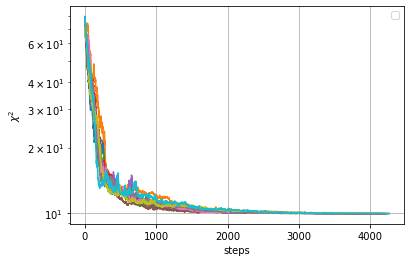

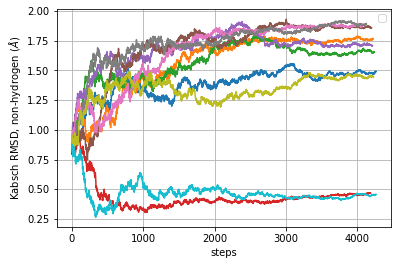

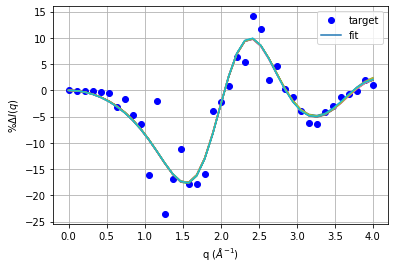

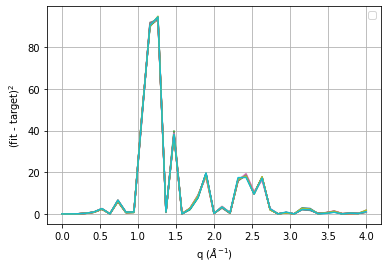

In [19]:
import numpy as np
import matplotlib.pyplot as p

data_file = 'data_stepsize_0.2_gamma_4.0_qmax_4.0_noise_0.90.npz'
f = np.load(data_file)
target_pcd = f['target_pcd']
chi2_path_array = f['chi2_path_array']
rmsd_path_array = f['rmsd_path_array']
final_pcd_array = f['final_pcd_array']
final_xyz_array = f['final_xyz_array']
counts_array = f['counts_array']
step_size = f['step_size']
cooling_rate = f['cooling_rate']
#noise_factor = f['noise_factor']
noise_factor = 0.5
qvector = f['qvector']
qmax = qvector[-1]

nruns = len(counts_array)
print(counts_array)
def nice_plot(
    data, xlab, ylab, legend=(), 
    log_scale=False, png_plot=False, fname=''
):
    p.figure()
    for i in range(data.shape[1]):
        c = int(counts_array[i])
        p.semilogy(data[:c, i]) if log_scale else p.plot(data[:c, i])
    p.xlabel(xlab)
    p.ylabel(ylab)
    p.legend(legend)
    p.grid()
    if png_plot:
        p.savefig(fname, dpi=300, facecolor='w', 
            edgecolor='w', orientation='portrait', 
            format='png', transparent=False, 
            bbox_inches='tight', pad_inches=0.1, 
            metadata=None)
    return

nice_plot(chi2_path_array, 'steps', '$\chi^2$', (), True, True, 
          'chi2_stepsize_%2.1f_gamma_%2.1f_qmax_%2.1f_noise_%3.2f.png' % 
          (step_size, cooling_rate, qmax, noise_factor))
nice_plot(rmsd_path_array, 'steps', r'Kabsch RMSD, non-hydrogen $(\AA)$', (), False, True,
                   'rmsd_stepsize_%2.1f_gamma_%2.1f_qmax_%2.1f_noise_%3.2f.png' % 
          (step_size, cooling_rate, qmax, noise_factor))
#nice_plot(final_pcd_array, 'q', r'%$\Delta I$', ())
#nice_plot(temp_path, 'steps', 'T', ())
p.figure()
p.plot(qvector, target_pcd, 'bo')
for i in range(nruns):
    p.plot(qvector, final_pcd_array[:, i])
p.xlabel('q $(\AA^{-1})$')
p.ylabel('%$\Delta I(q)$')
p.legend(('target', 'fit'))
p.grid()
fname = ('pcdfit_stepsize_%2.1f_gamma_%2.1f_qmax_%2.1f_noise_%3.2f.png' % 
          (step_size, cooling_rate, qmax, noise_factor))
p.savefig(fname, dpi=300, facecolor='w', 
        edgecolor='w', orientation='portrait', 
        format='png', transparent=False, 
        bbox_inches='tight', pad_inches=0.1, 
        metadata=None)

p.figure()
for i in range(nruns):
    p.plot(qvector, (final_pcd_array[:, i] - target_pcd)**2)
p.xlabel('q $(\AA^{-1})$')
p.ylabel('(fit - target)$^2$')
#p.ylim((0, 0.003))
p.legend(())
p.grid()
#ypos = 1
#xpos = 1
#plt.text(xpos, ypos, '$<\chi^2> = %6.4f$' % chi2, 
#             horizontalalignment='center',
#             verticalalignment='center',
#             bbox=dict(facecolor='white', alpha=1.0))

